In [1]:
from vizdoom import DoomGame
import time
import random
import numpy as np
import gym
from gym import Env
from gym.spaces import Box, Discrete
import cv2
import matplotlib.pyplot as plt
import torch
import os
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback

In [2]:
game = DoomGame()
game.load_config("github/VizDoom/scenarios/deadly_corridor_d1.cfg")
game.init()

In [3]:
actions = np.identity(game.get_available_buttons_size(), dtype=np.uint8)

In [4]:
# Loop through episodes 
episodes = 1
for episode in range(episodes): 
    # Create a new episode or game 
    game.new_episode()
    # Check the game isn't done 
    while not game.is_episode_finished(): 
        # Get the game state 
        state = game.get_state()
        # Get the game image 
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions),1)
        # Print rewward 
        print('reward:', reward) 
    print('Result:', game.get_total_reward())
    time.sleep(2)

reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.78125
reward: -0.0732421875
reward: -0.066375732421875
reward: 0.7206878662109375
reward: 0.6531219482421875
reward: 0.591888427734375
reward: 0.5363922119140625
reward: 0.4860992431640625
reward: 0.440521240234375
reward: 1.1711883544921875
reward: 1.0613861083984375
reward: 0.9618682861328125
reward: 0.09381103515625
reward: 0.0850067138671875
reward: 0.85675048828125
reward: -0.0033111572265625
reward: 0.04296875
reward: 0.81866455078125
reward: 0.741912841796875
reward: 0.6723480224609375
reward: 1.3845977783203125
reward: 1.254791259765625
reward: 1.13714599609375
reward: 1.0305328369140625
reward: 0.9339141845703125
reward: 0.8463592529296875
reward: 0.766998291015625
reward: 0.6950836181640625
reward: 1.39306640625
reward: 1.102630615234375
reward: 0.9992523193359375
reward: 0.9055633544921875
reward: 1.5838165283203125
reward: 1.435333251953125
reward: 1.4380340576171875
reward: 1.3032

In [5]:
game.close()

In [6]:
# Create Vizdoom OpenAI Gym Environment
class VizDoomGym(Env): 
    # Function that is called when we start the env
    def __init__(self, render=False, config='github/VizDoom/scenarios/deadly_corridor_d1.cfg'): 
        # Inherit from Env
        super().__init__()
        # Setup the game 
        self.game = DoomGame()
        self.game.load_config(config)
        
        # Render frame logic
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Start the game 
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(7)
        
        # Game variables: HEALTH DAMAGE_TAKEN HITCOUNT SELECTED_WEAPON_AMMO
        self.damage_taken = 0
        self.hitcount = 0
        self.ammo = 52 ## CHANGED
        
        
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step 
        actions = np.identity(7)
        movement_reward = self.game.make_action(actions[action], 4) 
        
        reward = 0 
        # Get all the other stuff we need to retun 
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            
            # Reward shaping
            game_variables = self.game.get_state().game_variables
            health, damage_taken, hitcount, ammo = game_variables
            
            # Calculate reward deltas
            damage_taken_delta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            hitcount_delta = hitcount - self.hitcount
            self.hitcount = hitcount
            ammo_delta = ammo - self.ammo
            self.ammo = ammo
            
            reward = movement_reward + damage_taken_delta*10 + hitcount_delta*200  + ammo_delta*5 
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        
        info = {"info":info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info 
    
    # Define how to render the game or environment 
    def render(): 
        pass
    
    # What happens when we start a new game 
    def reset(self): 
        # Game variables: HEALTH DAMAGE_TAKEN HITCOUNT SELECTED_WEAPON_AMMO
        self.damage_taken = 0
        self.hitcount = 0
        self.ammo = 52 ## CHANGED
        
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Call to close down the game
    def close(self): 
        self.game.close()

In [7]:
env = VizDoomGym(render=False)

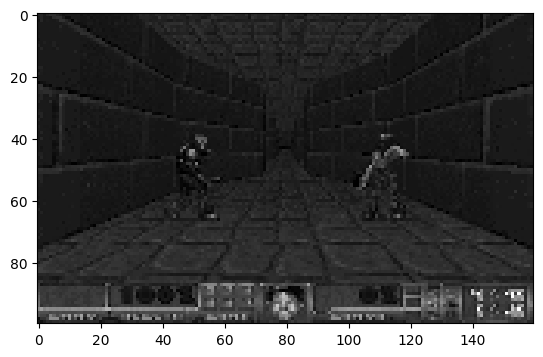

In [8]:
plt.imshow(env.reset(), cmap="gray")
env.close()

In [9]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [13]:
CHECKPOINT_DIR = './train/train_deadly_corridor'
LOG_DIR = './logs/log_deadly_corrior'

callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [14]:
env = VizDoomGym()
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, n_steps=8192, clip_range=.1, gamma=.95, gae_lambda=.9)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\Nikita\Desktop\RL_DOOM\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [15]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_deadly_corrior\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 205      |
|    ep_rew_mean     | 98       |
| time/              |          |
|    fps             | 33       |
|    iterations      | 1        |
|    time_elapsed    | 244      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 203          |
|    ep_rew_mean          | 136          |
| time/                   |              |
|    fps                  | 10           |
|    iterations           | 2            |
|    time_elapsed         | 1636         |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0024852334 |
|    clip_fraction        | 0.12         |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.94        |
|    explained_

In [16]:
env = VizDoomGym(config='github/VizDoom/scenarios/deadly_corridor_d2.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_deadly_corrior\PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42.6     |
|    ep_rew_mean     | 338      |
| time/              |          |
|    fps             | 32       |
|    iterations      | 1        |
|    time_elapsed    | 249      |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40.9        |
|    ep_rew_mean          | 332         |
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 2           |
|    time_elapsed         | 538         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.003392825 |
|    clip_fraction        | 0.178    

In [17]:
env = VizDoomGym(config='github/VizDoom/scenarios/deadly_corridor_d3.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_deadly_corrior\PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.4     |
|    ep_rew_mean     | 354      |
| time/              |          |
|    fps             | 29       |
|    iterations      | 1        |
|    time_elapsed    | 275      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 39.2         |
|    ep_rew_mean          | 335          |
| time/                   |              |
|    fps                  | 30           |
|    iterations           | 2            |
|    time_elapsed         | 542          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0044871424 |
|    clip_fraction        

In [18]:
env = VizDoomGym(config='github/VizDoom/scenarios/deadly_corridor_d4.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_deadly_corrior\PPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.7     |
|    ep_rew_mean     | 362      |
| time/              |          |
|    fps             | 60       |
|    iterations      | 1        |
|    time_elapsed    | 134      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 43.9         |
|    ep_rew_mean          | 340          |
| time/                   |              |
|    fps                  | 57           |
|    iterations           | 2            |
|    time_elapsed         | 282          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0038267705 |
|    clip_fraction        

In [19]:
env = VizDoomGym(config='github/VizDoom/scenarios/deadly_corridor_d5.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_deadly_corrior\PPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | 166      |
| time/              |          |
|    fps             | 33       |
|    iterations      | 1        |
|    time_elapsed    | 246      |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 23.9       |
|    ep_rew_mean          | 166        |
| time/                   |            |
|    fps                  | 37         |
|    iterations           | 2          |
|    time_elapsed         | 438        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.00449403 |
|    clip_fraction        | 0.287      |
|    cl

In [20]:
model.save("./train/train_deadly_corridor/fully_trained_model")

In [28]:
trained_model = PPO.load("./train/train_deadly_corridor/best_model_240000.zip")

In [30]:
env = VizDoomGym(config='github/VizDoom/scenarios/deadly_corridor_d1.cfg', render=True)

for episode in range(3):
    state = env.reset()
    done = False
    while not done:
        pred = trained_model.predict(state)
        state, _, done, _ = env.step(pred[0])
        time.sleep(1/20)
    time.sleep(2)
env.close()